In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import parse_version
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV #for Hyperparameter tuning (optional)
from sklearn.preprocessing import LabelEncoder #Label Encoding
from sklearn.model_selection import StratifiedKFold #K-Fold Cross-Validation
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

In [3]:
#import dataset
data = pd.read_csv('0717_Singapore_data_processed_bulkcarrier_v1.csv')

In [5]:
#Define X and y
X = data [['ship_age_c',
           'flag_performance_num_i',
           'ro_num_i',
           'company_performance_num_i',
           'last_deficiency_no_c',
           'classification_society_num_b',
           'last_inspection_state_to_num_b',
           'last_36_months_def_average_c',
           'last_36_months_def_max_c',
           'last_36_months_def_sum_c',
           'last_36_months_det_sum_c']]

y = data['deficiency_no_x']

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 13)

# GBRT (y1_pred)

In [7]:
#GridSearch (GBRT)

# Define the hyperparameter grid
param_grid_gbrt = {
    "n_estimators": [100, 300, 500],  # Number of boosting stages
    "learning_rate": [0.01, 0.05, 0.1],  # Step size shrinkage
    "max_depth": [3, 5, 7],  # Maximum depth of trees
    "min_samples_leaf": [5, 10, 20],  # Minimum samples per leaf node
    "subsample": [0.6, 0.8, 1.0],  # Fraction of samples used for each tree
    "max_features": [0.3, 0.5, 0.7]  # Fraction of features used per split
}

# Initialize GBRT model
gbrtreg = GradientBoostingRegressor()

# Initialize Grid Search with 5-fold cross-validation
grid_search_gbrt = GridSearchCV(
    estimator=gbrtreg, 
    param_grid=param_grid_gbrt, 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimize for lowest MSE
    n_jobs=-1,  # Use all CPU cores for parallel processing
    verbose=2  # Print progress updates
)

# Perform the grid search
grid_search_gbrt.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Parameters:", grid_search_gbrt.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.7, 'min_samples_leaf': 5, 'n_estimators': 300, 'subsample': 0.8}


In [55]:
#Run Model (GBRT)

# Initialize the Gradient Boosting Regressor with desired hyperparameters
params_gbrt = {
    "n_estimators": 300, #Number of boosting stages (trees) to run
    "learning_rate": 0.01, #determine contribution of each tree, lower LR = low variance 
    "max_depth": 3, #maximum depth of individual trees 
    "min_samples_leaf": 5, #Minimum samples required at a leaf node
    "subsample": 0.6, #Fraction of samples used to fit each tree
    "max_features": 0.5, #Fraction of features to consider at each split
    "loss": "squared_error" #Specifies the loss function to be optimised --> potential to explore other loss fn: MAE, "huber", "quantitle"
}

# Fit the model on the training set
gbrt = ensemble.GradientBoostingRegressor(**params_gbrt)
gbrt.fit(X_train, y_train)

#Make predictions
y1_pred = gbrt.predict(X_test)

# Evaluate the model
mse1 = mean_squared_error(y_test, y1_pred)
rmse1 = np.sqrt(mse1)  # Calculate RMSE by taking the square root of MSE
mae1 = mean_absolute_error(y_test, y1_pred)
r2_1 = r2_score(y_test, y1_pred)

print(f'Mean Squared Error: {mse1}') #average of the squares of the errors, lower = more accurate
print(f'Root Mean Squared Error: {rmse1}') #determines variance, how well the data fits?? 
print(f'Mean Absolute Error: {mae1}') #absolute differences of error, lower = more accurate
print(f'R² Score: {r2_1}')

Mean Squared Error: 17.80241018492448
Root Mean Squared Error: 4.219290246584665
Mean Absolute Error: 3.004566710260412
R² Score: 0.44522784841279994


In [57]:
#For Plot Cumulative Visulisation (GBRT)

# Retrain GBRT on the entire dataset
gbrt_full = ensemble.GradientBoostingRegressor(**params_gbrt)
gbrt_full.fit(X, y.values.ravel())  # Use entire dataset

# Predict deficiency numbers for ALL data points
y1_pred_full = gbrt_full.predict(X)

# Create a DataFrame with both actual and predicted deficiency numbers
results1_full = pd.DataFrame({
    'predicted_deficiency': y1_pred_full,
    'actual_deficiency': y.values.flatten()
})

# Rank by predicted deficiency and compute cumulative sum
results1_pred_ranked = results1_full.sort_values(by='predicted_deficiency', ascending=False).reset_index(drop=True)
results1_pred_ranked['cumulative_actual_deficiency'] = results1_pred_ranked['actual_deficiency'].cumsum()

# Rank by actual deficiency and compute cumulative sum
results_actual_ranked = results1_full.sort_values(by='actual_deficiency', ascending=False).reset_index(drop=True)
results_actual_ranked['cumulative_actual_deficiency'] = results_actual_ranked['actual_deficiency'].cumsum()

# XGBoost (y2_pred)

In [11]:
!pip install xgboost

In [12]:
# GridSearch (XGBoost)

# Define the hyperparameter grid
param_grid_xgb = {
    "n_estimators": [100, 300, 500],  
    "learning_rate": [0.01, 0.05, 0.1],  
    "max_depth": [3, 5, 7],  
    "min_child_weight": [1, 5, 10],  # Changed from `min_samples_leaf`
    "subsample": [0.6, 0.8, 1.0],  
    "colsample_bytree": [0.3, 0.5, 0.7]  # Changed from `max_features`
}

# Initialize model
xgb_model = XGBRegressor()

# Initialize Grid Search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb, 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimize for lowest MSE
    n_jobs=-1,  # Use all CPU cores for parallel processing
    verbose=2  # Print progress updates
)

# Perform the grid search
grid_search_xgb.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Parameters:", grid_search_xgb.best_params_)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6}


In [59]:
from xgboost import XGBRegressor

# Run model (XGBoost)

# Initialize the XGBoost with desired hyperparameters
params_xgb = {
    "n_estimators": 500,  
    "learning_rate": 0.01,  
    "max_depth":3,  
    "min_child_weight": 1,  # Changed from `min_samples_leaf`
    "subsample": 0.6 ,  
    "colsample_bytree": 0.7  # Changed from `max_features`
}
xgb_model = XGBRegressor(**params_xgb)
xgb_model.fit(X_train, y_train)

#Make predictions
y2_pred = xgb_model.predict(X_test)

# Evaluate the model
mse2 = mean_squared_error(y_test, y2_pred)
rmse2 = np.sqrt(mse2)  # Calculate RMSE by taking the square root of MSE
mae2 = mean_absolute_error(y_test, y2_pred)
r2_2 = r2_score(y_test, y2_pred)

print(f'Mean Squared Error: {mse2}') #average of the squares of the errors, lower = more accurate
print(f'Root Mean Squared Error: {rmse2}') #determines variance, how well the data fits?? 
print(f'Mean Absolute Error: {mae2}') #absolute differences of error, lower = more accurate
print(f'R² Score: {r2_2}')

Mean Squared Error: 19.384082408551347
Root Mean Squared Error: 4.402735786820661
Mean Absolute Error: 3.10496773252954
R² Score: 0.3959385840102614


In [61]:
#### Retrain GBRT on the entire dataset
xgb_full = XGBRegressor(**params_xgb)
xgb_full.fit(X, y.values.ravel())  # Use entire dataset

# Predict deficiency numbers for ALL data points
y2_pred_full = xgb_full.predict(X)

# Create a DataFrame with both actual and predicted deficiency numbers
results2_full = pd.DataFrame({
    'predicted_deficiency': y2_pred_full,
    'actual_deficiency': y.values.flatten()
})

# Rank by predicted deficiency and compute cumulative sum
results2_pred_ranked = results2_full.sort_values(by='predicted_deficiency', ascending=False).reset_index(drop=True)
results2_pred_ranked['cumulative_actual_deficiency'] = results2_pred_ranked['actual_deficiency'].cumsum()

# Rank by actual deficiency and compute cumulative sum
results_actual_ranked = results2_full.sort_values(by='actual_deficiency', ascending=False).reset_index(drop=True)
results_actual_ranked['cumulative_actual_deficiency'] = results_actual_ranked['actual_deficiency'].cumsum()

# Random Forest Regressor (y3_pred)

In [4]:
#GridSearch (RF)

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider per split
}

# Initialize Random Forest
rf = RandomForestRegressor()

# Perform Grid Search with 5-fold cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid_rf, 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimize for lowest error
    n_jobs=-1,  # Use all processors for faster computation
    verbose=2  # Show progress
)


# Perfrom the Grid Search
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search_rf.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [63]:
#Run Model (RF)

# Initialize the Gradient Boosting Regressor with desired hyperparameters
params_rf = {
    'n_estimators': 200,  # Number of trees
    'max_depth': 20,  # Maximum depth of trees
    'min_samples_split': 10,  # Minimum samples to split a node
    'min_samples_leaf': 1,  # Minimum samples at a leaf node
    'max_features': 'log2',  # Number of features to consider per split
}

# Fit the model on the training set
rf = RandomForestRegressor(**params_rf)
rf.fit(X_train, y_train)

#Make predictions
y3_pred = rf.predict(X_test)

# Evaluate the model
mse3 = mean_squared_error(y_test, y3_pred)
rmse3 = np.sqrt(mse3)  # Calculate RMSE by taking the square root of MSE
mae3 = mean_absolute_error(y_test, y3_pred)
r2_3 = r2_score(y_test, y3_pred)

print(f'Mean Squared Error: {mse3}') #average of the squares of the errors, lower = more accurate
print(f'Root Mean Squared Error: {rmse3}') #determines variance, how well the data fits?? 
print(f'Mean Absolute Error: {mae3}') #absolute differences of error, lower = more accurate
print(f'R² Score: {r2_3}')

Mean Squared Error: 18.973653030715685
Root Mean Squared Error: 4.355875690457165
Mean Absolute Error: 3.039489041355218
R² Score: 0.40872869426226


In [67]:
#Plot Cumulative Visulisation (RF)

# Retrain RF on the entire dataset
rf_full = RandomForestRegressor(**params_rf)
rf_full.fit(X, y.values.ravel())  # Use entire dataset

# Predict deficiency numbers for ALL data points
y3_pred_full = rf_full.predict(X)

# Create a DataFrame with both actual and predicted deficiency numbers
results3_full = pd.DataFrame({
    'predicted_deficiency': y3_pred_full,
    'actual_deficiency': y.values.flatten()
})

# Rank by predicted deficiency and compute cumulative sum
results3_pred_ranked = results3_full.sort_values(by='predicted_deficiency', ascending=False).reset_index(drop=True)
results3_pred_ranked['cumulative_actual_deficiency'] = results3_pred_ranked['actual_deficiency'].cumsum()

# Rank by actual deficiency and compute cumulative sum
results_actual_ranked = results3_full.sort_values(by='actual_deficiency', ascending=False).reset_index(drop=True)
results_actual_ranked['cumulative_actual_deficiency'] = results_actual_ranked['actual_deficiency'].cumsum()

# Stacked Model (GBRT+XGBoost: Stacked with Ridge)(y4_pred)

In [7]:
#RandomizedSearchCV  (GridSerach is taking too long)

# Base models
gbrt = GradientBoostingRegressor()
xgb = XGBRegressor(verbosity=0)

# Meta-model (final estimator)
meta_model1 = Ridge()

stacked_model1 = StackingRegressor(
    estimators=[('gbrt', gbrt), ('xgb', xgb)],
    final_estimator=meta_model1,
    passthrough=True  # Optional: include original features for meta-model
)

# Define parameter distribution for RandomizedSearchCV
param_dist_gbrtxgb = {
    'gbrt__n_estimators': [100, 300, 500, 700],
    'gbrt__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gbrt__max_depth': [3, 5, 7, 9],
    'gbrt__min_samples_leaf': [5, 10, 20],
    'gbrt__subsample': [0.6, 0.8, 1.0],
    'gbrt__max_features': [0.3, 0.5, 0.7, 1.0],

    'xgb__n_estimators': [100, 300, 500],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.3, 0.5, 0.7],

    'final_estimator__alpha': [0.1, 1.0, 10.0]  # Ridge regularization strength
}

# Perform RandomizedSearchCV with 5-fold cross-validation
random_search_gbrtxgb = RandomizedSearchCV(
    estimator=stacked_model1,
    param_distributions=param_dist_gbrtxgb,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all processors for faster computation
    verbose=2,  # Show progress
    random_state=42  # Set a random seed for reproducibility
)

# Perform the Randomized Search
random_search_gbrtxgb.fit(X_train, y_train.values.ravel())

# Get the best parameters
print("Best Parameters:", random_search_gbrtxgb.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [84]:
params_gbrt = {
    "n_estimators": 300, #Number of boosting stages (trees) to run
    "learning_rate": 0.01, #determine contribution of each tree, lower LR = low variance 
    "max_depth": 3, #maximum depth of individual trees 
    "min_samples_leaf": 5, #Minimum samples required at a leaf node
    "subsample": 0.6, #Fraction of samples used to fit each tree
    "max_features": 0.5, #Fraction of features to consider at each split
    "loss": "squared_error" #Specifies the loss function to be optimised --> potential to explore other loss fn: MAE, "huber", "quantitle"
}

params_xgb = {
    "n_estimators": 500,  
    "learning_rate": 0.01,  
    "max_depth":3,  
    "min_child_weight": 1,  # Changed from `min_samples_leaf`
    "subsample": 0.6 ,  
    "colsample_bytree": 0.7  # Changed from `max_features`
}

# 3️⃣ Train Base Models
xgb = XGBRegressor(**params_xgb)
gbrt = GradientBoostingRegressor(**params_gbrt)

xgb.fit(X_train, y_train)
gbrt.fit(X_train, y_train)

# 4️⃣ Make predictions on Train & Test Data
train_pred_xgb = xgb.predict(X_train)
train_pred_gbrt = gbrt.predict(X_train)

test_pred_xgb = xgb.predict(X_test)
test_pred_gbrt = gbrt.predict(X_test)

# 5️⃣ Prepare Stacking Dataset
X_train_stack = np.column_stack((train_pred_xgb, train_pred_gbrt))  # Combine predictions
X_test_stack = np.column_stack((test_pred_xgb, test_pred_gbrt))

# 6️⃣ Train Meta-Model (Linear Regression as Meta-Learner)
meta_model1 = Ridge()
meta_model1.fit(X_train_stack, y_train)

# 7️⃣ Make Final Predictions
y4_pred_final = meta_model1.predict(X_test_stack)

# 8️⃣ Evaluate Performance
rmse4 = np.sqrt(mean_squared_error(y_test, y4_pred_final))
mse4 = mean_squared_error(y_test, y4_pred_final)
mae4 = mean_absolute_error(y_test, y4_pred_final)
r2_4 = r2_score(y_test, y4_pred_final)

# Print all evaluation metrics
print(f"Stacked Model MSE: {mse4:.3f}")
print(f"Stacked Model RMSE: {rmse4:.3f}")
print(f"Stacked Model MAE: {mae4:.3f}")
print(f"Stacked Model R² Score: {r2_4:.3f}")

Stacked Model MSE: 23.338
Stacked Model RMSE: 4.831
Stacked Model MAE: 3.267
Stacked Model R² Score: 0.273


In [15]:
#### Retrain meta_model1 on the entire dataset
meta_model_full1 = Ridge()
meta_model_full1.fit(X, y.values.ravel())  # Use entire dataset

# Predict deficiency numbers for ALL data points
y4_pred_full = meta_model_full1.predict(X)

# Create a DataFrame with both actual and predicted deficiency numbers
results4_full = pd.DataFrame({
    'predicted_deficiency': y4_pred_full,
    'actual_deficiency': y.values.flatten()
})

# Rank by actual deficiency and compute cumulative sum
results_actual_ranked = results4_full.sort_values(by='actual_deficiency', ascending=False).reset_index(drop=True)
results_actual_ranked['cumulative_actual_deficiency'] = results_actual_ranked['actual_deficiency'].cumsum()

# Rank by predicted deficiency and compute cumulative sum
results4_pred_ranked = results4_full.sort_values(by='predicted_deficiency', ascending=False).reset_index(drop=True)
results4_pred_ranked['cumulative_actual_deficiency'] = results4_pred_ranked['actual_deficiency'].cumsum()

# Stacked Model (GBRT+RF: Stacked with Ridge)(y5_pred)

In [ ]:
#GridSearch (GBRT+RF)

# Base models
gbrt = GradientBoostingRegressor()
rf = RandomForestRegressor(random_state=42)

# Meta-model (final estimator)
meta_model2 = Ridge()

stacked_model2 = StackingRegressor(
    estimators=[('gbrt', gbrt), ('rf', rf)],
    final_estimator=meta_model2,
    passthrough=True  # Optional: include original features for meta-model
)


#Define parameter grid
param_grid_gbrtrf = {
    'gbrt__n_estimators': [100, 300],
    'gbrt__learning_rate': [0.05, 0.1],
    'gbrt__max_depth': [3, 5],
    'gbrt__min_samples_leaf': [5, 10, 20],  # Minimum samples per leaf node
    'gbrt__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for each tree
    'gbrt__max_features': [0.3, 0.5, 0.7],  # Fraction of features used per split

    'rf__n_estimators': [50, 100, 200],  # Number of trees
    'rf__max_depth': [None, 10, 20],  # Maximum depth of trees
    'rf__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'rt__min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'rf__max_features': ['sqrt', 'log2'],  # Number of features to consider per split
    
    'final_estimator__alpha': [0.1, 1.0]  # Ridge regularization strength
}


# Perform Grid Search with 5-fold cross-validation
grid_search_gbrtrf = GridSearchCV(
    estimator=stacked_model2, 
    param_grid=param_grid_gbrtrf, 
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all processors for faster computation
    verbose=2  # Show progress
)

# Perfrom the Grid Search
grid_search_gbrtrf.fit(X_train, y_train.values.ravel())

# Get the best parameters
print("Best Parameters:", grid_search_gbrtrf.best_params_)

In [90]:
params_gbrt = {
    "n_estimators": 300, #Number of boosting stages (trees) to run
    "learning_rate": 0.01, #determine contribution of each tree, lower LR = low variance 
    "max_depth": 3, #maximum depth of individual trees 
    "min_samples_leaf": 5, #Minimum samples required at a leaf node
    "subsample": 0.6, #Fraction of samples used to fit each tree
    "max_features": 0.5, #Fraction of features to consider at each split
    "loss": "squared_error" #Specifies the loss function to be optimised --> potential to explore other loss fn: MAE, "huber", "quantitle"
}

params_rf = {
    'n_estimators': 200,  # Number of trees
    'max_depth': 10,  # Maximum depth of trees
    'min_samples_split': 5,  # Minimum samples to split a node
    'min_samples_leaf': 2,  # Minimum samples at a leaf node
    'max_features': 'sqrt',  # Number of features to consider per split
}


# 3️⃣ Train Base Models
gbrt = GradientBoostingRegressor(**params_gbrt)
rf = RandomForestRegressor(**params_rf)

rf.fit(X_train, y_train)
gbrt.fit(X_train, y_train)

# 4️⃣ Make predictions on Train & Test Data
train_pred_rf = rf.predict(X_train)
train_pred_gbrt = gbrt.predict(X_train)

test_pred_rf = rf.predict(X_test)
test_pred_gbrt = gbrt.predict(X_test)

# 5️⃣ Prepare Stacking Dataset
X_train_stack = np.column_stack((train_pred_rf, train_pred_gbrt))  # Combine predictions
X_test_stack = np.column_stack((test_pred_rf, test_pred_gbrt))

# 6️⃣ Train Meta-Model (Linear Regression as Meta-Learner)
meta_model2 = LinearRegression()
meta_model2.fit(X_train_stack, y_train)

# 7️⃣ Make Final Predictions
y5_pred_final = meta_model2.predict(X_test_stack)

# 8️⃣ Evaluate Performance
rmse5 = np.sqrt(mean_squared_error(y_test, y5_pred_final))
mse5 = mean_squared_error(y_test, y5_pred_final)
mae5 = mean_absolute_error(y_test, y5_pred_final)
r2_5 = r2_score(y_test, y5_pred_final)

# Print all evaluation metrics
print(f"Stacked Model MSE: {mse5:.3f}")
print(f"Stacked Model RMSE: {rmse5:.3f}")
print(f"Stacked Model MAE: {mae5:.3f}")
print(f"Stacked Model R² Score: {r2_5:.3f}")


Stacked Model MSE: 21.789
Stacked Model RMSE: 4.668
Stacked Model MAE: 3.156
Stacked Model R² Score: 0.321


In [102]:
#### Retrain meta_model2 on the entire dataset
meta_model_full2 = LinearRegression()
meta_model_full2.fit(X, y.values.ravel())  # Use entire dataset

# Predict deficiency numbers for ALL data points
y5_pred_full = meta_model_full2.predict(X)

# Create a DataFrame with both actual and predicted deficiency numbers
results5_full = pd.DataFrame({
    'predicted_deficiency': y5_pred_full,
    'actual_deficiency': y.values.flatten()
})

# Rank by actual deficiency and compute cumulative sum
results_actual_ranked = results5_full.sort_values(by='actual_deficiency', ascending=False).reset_index(drop=True)
results_actual_ranked['cumulative_actual_deficiency'] = results_actual_ranked['actual_deficiency'].cumsum()

# Rank by predicted deficiency and compute cumulative sum
results5_pred_ranked = results5_full.sort_values(by='predicted_deficiency', ascending=False).reset_index(drop=True)
results5_pred_ranked['cumulative_actual_deficiency'] = results5_pred_ranked['actual_deficiency'].cumsum()

# Cummulative Visualisation

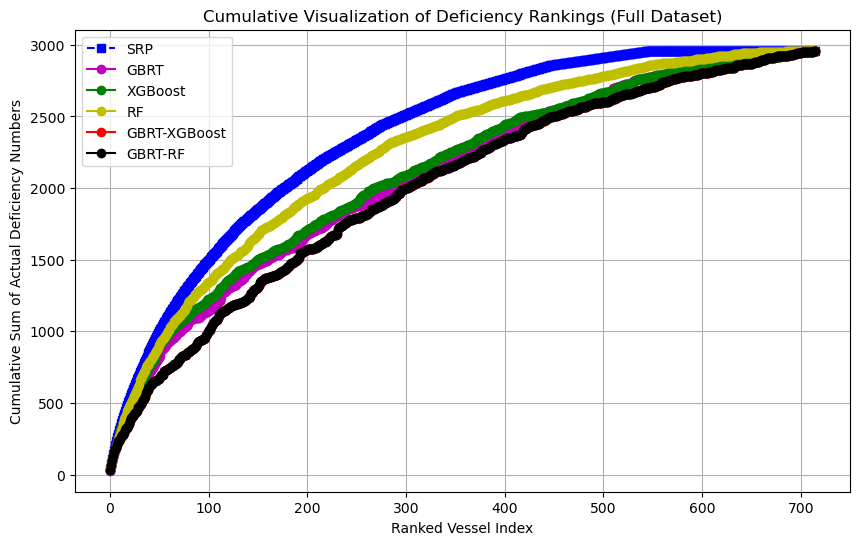

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot cumulative curve for actual ranking
plt.plot(results_actual_ranked.index, results_actual_ranked['cumulative_actual_deficiency'], 
        marker='s', linestyle='--', color='b', label="SRP")

# Plot cumulative curve for predicted ranking
plt.plot(results1_pred_ranked.index, results1_pred_ranked['cumulative_actual_deficiency'], 
        marker='o', linestyle='-', color='m', label="GBRT")

plt.plot(results2_pred_ranked.index, results2_pred_ranked['cumulative_actual_deficiency'], 
        marker='o', linestyle='-', color='g', label="XGBoost")

plt.plot(results3_pred_ranked.index, results3_pred_ranked['cumulative_actual_deficiency'], 
        marker='o', linestyle='-', color='y', label="RF")

plt.plot(results4_pred_ranked.index, results4_pred_ranked['cumulative_actual_deficiency'], 
        marker='o', linestyle='-', color='r', label="GBRT-XGBoost")

plt.plot(results5_pred_ranked.index, results5_pred_ranked['cumulative_actual_deficiency'], 
        marker='o', linestyle='-', color='k', label="GBRT-RF")


# Formatting
plt.xlabel("Ranked Vessel Index")
plt.ylabel("Cumulative Sum of Actual Deficiency Numbers")
plt.title("Cumulative Visualization of Deficiency Rankings (Full Dataset)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()